In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import ast
import json
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [31]:
# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [32]:
# Load the data
df = pd.read_csv('pr_analysis_data_open_and_close.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

# Check first few rows
df.head(3)

Dataset shape: (1025, 16)

Column names:
['repository', 'pr_number', 'title', 'url', 'state', 'merged_at', 'review_comments_count', 'issue_comments_count', 'all_comments', 'year', 'month', 'year_month', 'total_comments', 'category', 'dependency_info', 'change_request_categories']


,repository,pr_number,title,url,state,merged_at,review_comments_count,issue_comments_count,all_comments,year,month,year_month,total_comments,category,dependency_info,change_request_categories
0,jboss/jboss-parent-pom,399,Bump com.puppycrawl.tools:checkstyle from 10.2...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-03-05 14:21:39+00:00,0,0,[],2025.0,3.0,2025-03,0,Dependency Updates,{'dependency': 'com.puppycrawl.tools:checkstyl...,{}
1,jboss/jboss-parent-pom,398,Bump org.apache.maven.plugins:maven-install-pl...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-02-28 12:48:55+00:00,0,0,[],2025.0,2.0,2025-02,0,Dependency Updates,{'dependency': 'org.apache.maven.plugins:maven...,{}
2,jboss/jboss-parent-pom,397,Bump org.apache.maven.plugins:maven-deploy-plu...,https://github.com/jboss/jboss-parent-pom/pull...,closed,2025-02-27 12:44:29+00:00,0,0,[],2025.0,2.0,2025-02,0,Dependency Updates,{'dependency': 'org.apache.maven.plugins:maven...,{}


In [34]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check PR states
print("\nPR states:")
print(df['state'].value_counts())

# Check merge status
df['is_merged'] = df['merged_at'].notnull().astype(int)
print("\nMerge status:")
print(df['is_merged'].value_counts())
print(f"Percentage merged: {df['is_merged'].mean() * 100:.2f}%")

Missing values:
repository                     0
pr_number                      0
title                          0
url                            0
state                          0
merged_at                    165
review_comments_count          0
issue_comments_count           0
all_comments                   0
year                         165
month                        165
year_month                   165
total_comments                 0
category                       0
dependency_info              797
change_request_categories      0
dtype: int64

PR states:
state
closed    1002
open        23
Name: count, dtype: int64

Merge status:
is_merged
1    860
0    165
Name: count, dtype: int64
Percentage merged: 83.90%


In [7]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Further investigation of dependency_info nulls
dependency_nulls = df['dependency_info'].isnull().sum()
print(f"\nNull values in dependency_info: {dependency_nulls} ({dependency_nulls/len(df)*100:.2f}%)")

# Check relationship between dependency_info nulls and PR category
dependency_category_nulls = df[df['category'] == 'Dependency Updates']['dependency_info'].isnull().sum()
print(f"Dependency Updates PRs with null dependency_info: {dependency_category_nulls} out of {len(df[df['category'] == 'Dependency Updates'])}")
print(f"Non-Dependency Updates PRs with null dependency_info: {dependency_nulls - dependency_category_nulls} out of {len(df[df['category'] != 'Dependency Updates'])}")


Missing values:
repository                     0
pr_number                      0
title                          0
url                            0
state                          0
merged_at                      0
review_comments_count          0
issue_comments_count           0
all_comments                   0
year                           0
month                          0
year_month                     0
total_comments                 0
category                       0
dependency_info              682
change_request_categories      0
dtype: int64

Null values in dependency_info: 682 (79.30%)
Dependency Updates PRs with null dependency_info: 139 out of 317
Non-Dependency Updates PRs with null dependency_info: 543 out of 543


Comment statistics by merge status:
   is_merged  total_prs  prs_with_comments  avg_comments  max_comments  \
0          0        165                138      2.496970            30   
1          1        860                325      1.262791            39   

   total_comments  percent_with_comments  
0             412                  83.64  
1            1086                  37.79  


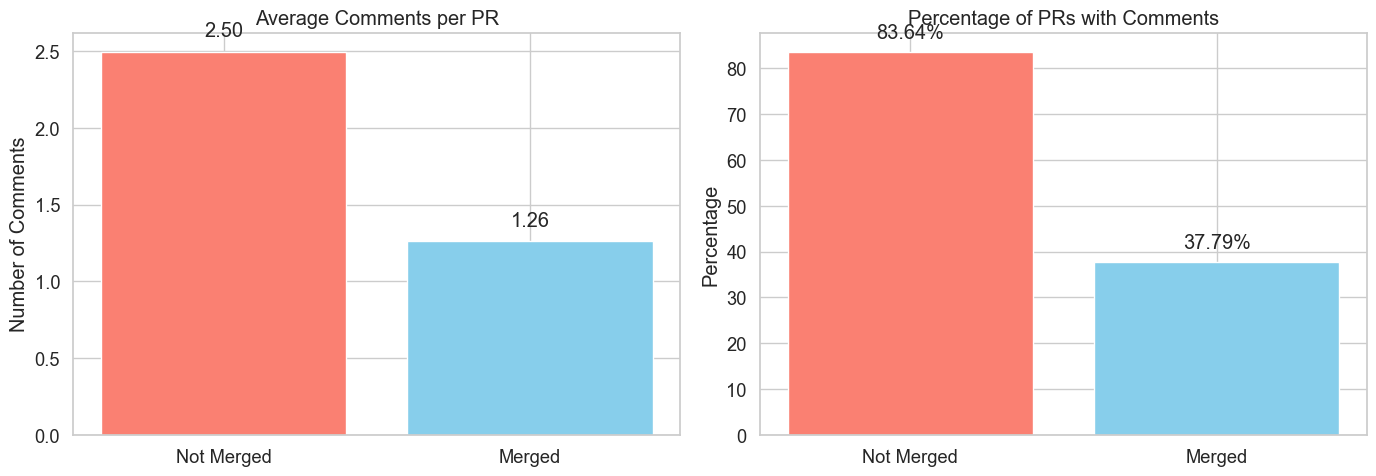

In [35]:
# Group by merge status and analyze comments
comment_stats = df.groupby('is_merged').agg(
    total_prs=('pr_number', 'count'),
    prs_with_comments=('total_comments', lambda x: (x > 0).sum()),
    avg_comments=('total_comments', 'mean'),
    max_comments=('total_comments', 'max'),
    total_comments=('total_comments', 'sum')
).reset_index()

comment_stats['percent_with_comments'] = (comment_stats['prs_with_comments'] / comment_stats['total_prs'] * 100).round(2)

print("Comment statistics by merge status:")
print(comment_stats)

# Visualize comment statistics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average comments
axes[0].bar(['Not Merged', 'Merged'], comment_stats['avg_comments'], color=['salmon', 'skyblue'])
axes[0].set_title('Average Comments per PR')
axes[0].set_ylabel('Number of Comments')
for i, v in enumerate(comment_stats['avg_comments']):
    axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center')

# Percentage with comments
axes[1].bar(['Not Merged', 'Merged'], comment_stats['percent_with_comments'], color=['salmon', 'skyblue'])
axes[1].set_title('Percentage of PRs with Comments')
axes[1].set_ylabel('Percentage')
for i, v in enumerate(comment_stats['percent_with_comments']):
    axes[1].text(i, v + 3, f"{v:.2f}%", ha='center')

plt.tight_layout()
plt.show()

Repository statistics:
               repository  total_prs  merged_prs  merge_rate  non_merged
0          Netflix/falcor        536         461       86.01       13.99
1           eclipse/Xpect        126         106       84.13       15.87
2  jboss/jboss-parent-pom        363         293       80.72       19.28


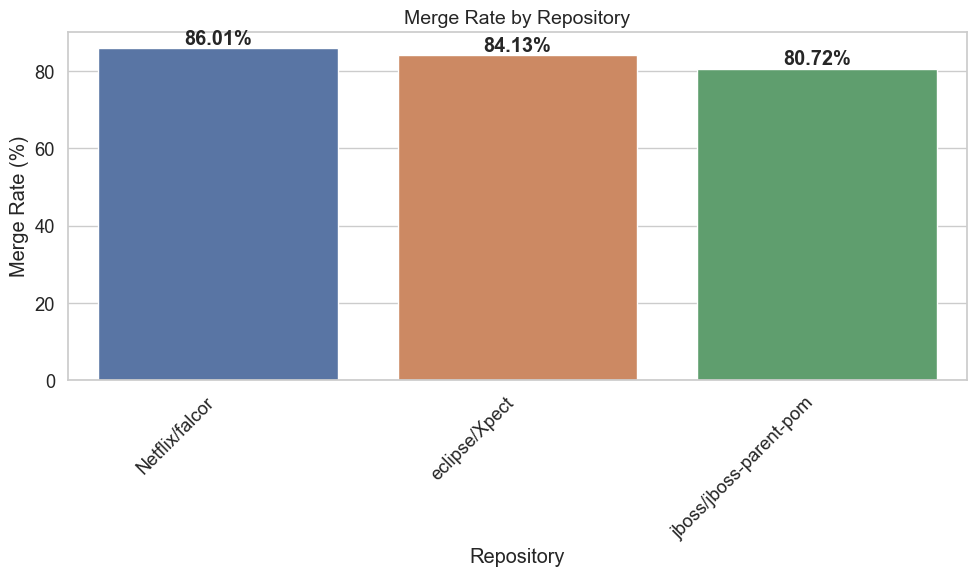

In [38]:
# Analyze merge rates by repository
repo_stats = df.groupby('repository').agg(
    total_prs=('pr_number', 'count'),
    merged_prs=('is_merged', 'sum')
).reset_index()

repo_stats['merge_rate'] = (repo_stats['merged_prs'] / repo_stats['total_prs'] * 100).round(2)
repo_stats['non_merged'] = ((repo_stats['total_prs'] - repo_stats['merged_prs']) / repo_stats['total_prs'] * 100).round(2)

print("Repository statistics:")
print(repo_stats)

# Visualize merge rates by repository
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='repository', y='merge_rate', data=repo_stats)
plt.title('Merge Rate by Repository', fontsize=14)
plt.ylabel('Merge Rate (%)')
plt.xlabel('Repository')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, row in enumerate(repo_stats.itertuples()):
    plt.text(i, row.merge_rate + 1, f"{row.merge_rate}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

PR category statistics:
                   category  total_prs  merged_prs  merge_rate  non_merged
1  Code Style & Refactoring         19          18       94.74        5.26
0                 Bug Fixes        140         127       90.71        9.29
3     Documentation Updates          9           8       88.89       11.11
4         Feature Additions        115         102       88.70       11.30
5                     Other        315         276       87.62       12.38
6  Performance Improvements         14          12       85.71       14.29
2        Dependency Updates        412         317       76.94       23.06
7            Security Fixes          1           0        0.00      100.00


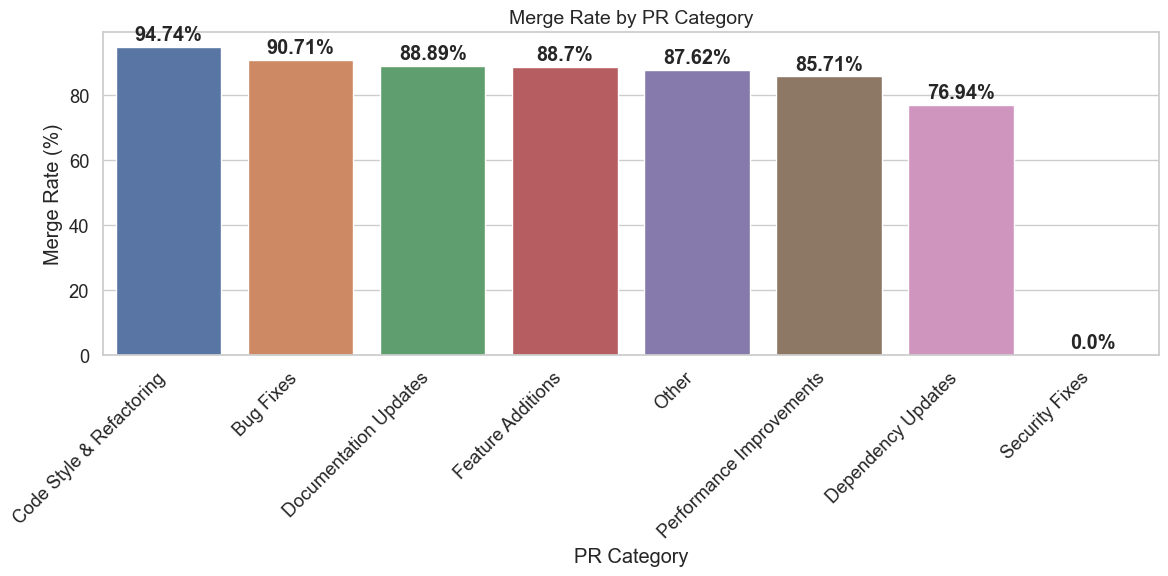

In [41]:
# Analyze merge rates by PR category
category_stats = df.groupby('category').agg(
    total_prs=('pr_number', 'count'),
    merged_prs=('is_merged', 'sum')
).reset_index()

category_stats['merge_rate'] = (category_stats['merged_prs'] / category_stats['total_prs'] * 100).round(2)
category_stats['non_merged'] = ((category_stats['total_prs'] - category_stats['merged_prs'])/ category_stats['total_prs'] * 100).round(2)
category_stats = category_stats.sort_values('merge_rate', ascending=False)

print("PR category statistics:")
print(category_stats)

# Visualize merge rates by category
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='category', y='merge_rate', data=category_stats)
plt.title('Merge Rate by PR Category', fontsize=14)
plt.ylabel('Merge Rate (%)')
plt.xlabel('PR Category')
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for i, row in enumerate(category_stats.itertuples()):
    plt.text(i, row.merge_rate + 2, f"{row.merge_rate}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Change request statistics:
   has_change_requests  total_prs  merged_prs  merge_rate
0                    0        722         642       88.92
1                    1        303         218       71.95

Dependency info statistics:
   has_dependency_info  total_prs  merged_prs  merge_rate
0                    0        797         682       85.57
1                    1        228         178       78.07


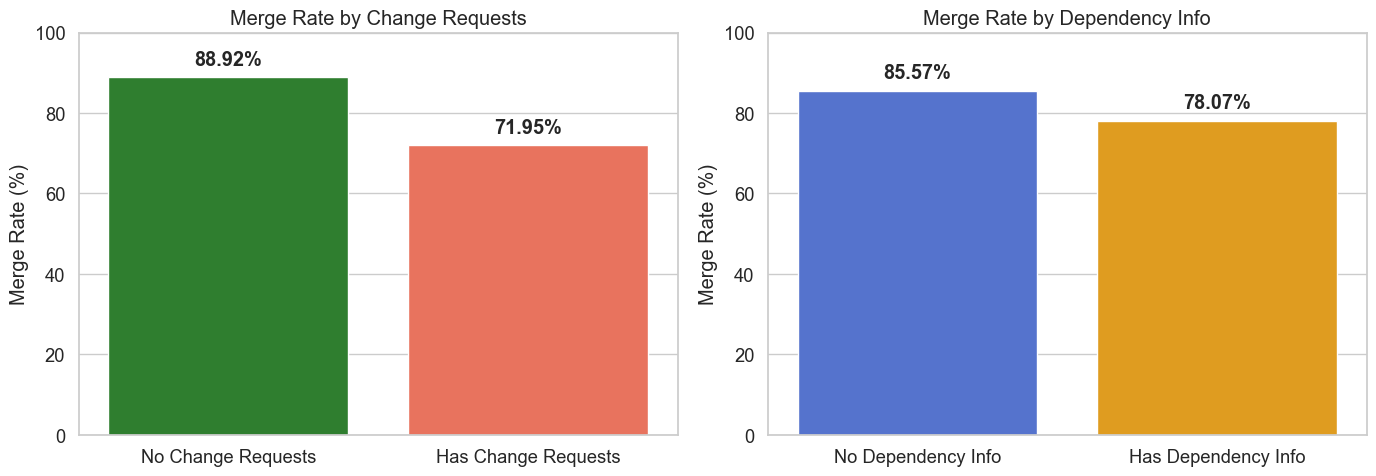

In [42]:
# Helper function to parse change_request_categories
def parse_categories(cat_str):
    if not cat_str or cat_str == '{}':
        return {}
    
    try:
        # Replace single quotes with double quotes for valid JSON
        cat_str = cat_str.replace("'", '"').replace("None", "null")
        return json.loads(cat_str)
    except:
        # print(f"Error parsing: {cat_str}")
        return {}

# Add a column indicating whether the PR has change requests
df['has_change_requests'] = df['change_request_categories'].apply(
    lambda x: 0 if x == '{}' else 1
)

# Analysis of change requests and merge rates
change_request_stats = df.groupby('has_change_requests').agg(
    total_prs=('pr_number', 'count'),
    merged_prs=('is_merged', 'sum')
).reset_index()

change_request_stats['merge_rate'] = (
    change_request_stats['merged_prs'] / change_request_stats['total_prs'] * 100
).round(2)

print("Change request statistics:")
print(change_request_stats)

# Analyze dependency info
df['has_dependency_info'] = df['dependency_info'].apply(
    lambda x: 0 if pd.isna(x) or x == 'None' or x == '{}' else 1
)

dependency_stats = df.groupby('has_dependency_info').agg(
    total_prs=('pr_number', 'count'),
    merged_prs=('is_merged', 'sum')
).reset_index()

dependency_stats['merge_rate'] = (
    dependency_stats['merged_prs'] / dependency_stats['total_prs'] * 100
).round(2)

print("\nDependency info statistics:")
print(dependency_stats)

# Visualize these factors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Change requests plot
sns.barplot(x=['No Change Requests', 'Has Change Requests'], 
            y=change_request_stats['merge_rate'], 
            palette=['forestgreen', 'tomato'],
            ax=ax1)
ax1.set_title('Merge Rate by Change Requests')
ax1.set_ylabel('Merge Rate (%)')
ax1.set_ylim(0, 100)

for i, v in enumerate(change_request_stats['merge_rate']):
    ax1.text(i, v + 3, f"{v:.2f}%", ha='center', fontweight='bold')

# Dependency info plot
sns.barplot(x=['No Dependency Info', 'Has Dependency Info'], 
            y=dependency_stats['merge_rate'], 
            palette=['royalblue', 'orange'],
            ax=ax2)
ax2.set_title('Merge Rate by Dependency Info')
ax2.set_ylabel('Merge Rate (%)')
ax2.set_ylim(0, 100)

for i, v in enumerate(dependency_stats['merge_rate']):
    ax2.text(i, v + 3, f"{v:.2f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Total PRs for modeling: 1002
Merged PRs: 860 (85.83%)
Non-merged PRs: 142 (14.17%)


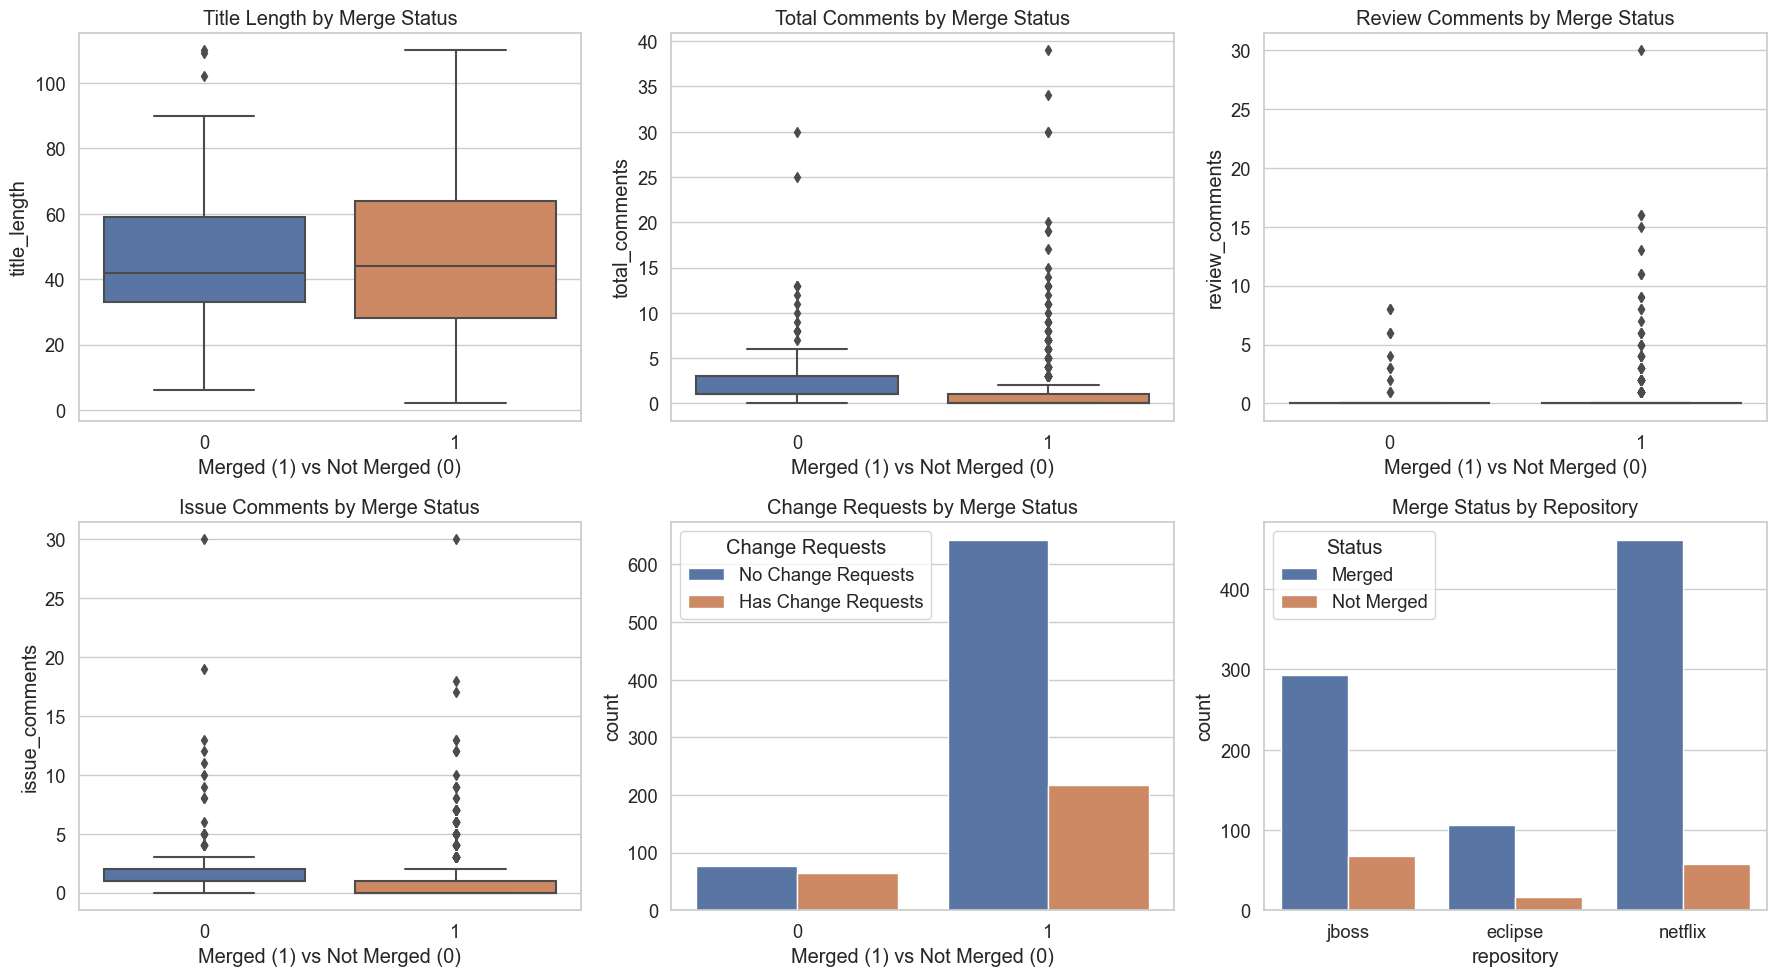

In [44]:
# Focus on closed PRs only - open PRs don't have a definitive outcome yet
df_closed = df[df['state'] == 'closed'].copy()

# Create features for the prediction model
features = pd.DataFrame({
    # Repository features (one-hot encoded)
    'is_jboss': (df_closed['repository'] == 'jboss/jboss-parent-pom').astype(int),
    'is_eclipse': (df_closed['repository'] == 'eclipse/Xpect').astype(int),
    'is_netflix': (df_closed['repository'] == 'Netflix/falcor').astype(int),
    
    # PR characteristics
    'title_length': df_closed['title'].str.len(),
    'has_comments': (df_closed['total_comments'] > 0).astype(int),
    'total_comments': df_closed['total_comments'],
    'review_comments': df_closed['review_comments_count'],
    'issue_comments': df_closed['issue_comments_count'],
    
    # PR category features (one-hot encoded)
    'is_dependency_update': (df_closed['category'] == 'Dependency Updates').astype(int),
    'is_feature': (df_closed['category'] == 'Feature Additions').astype(int),
    'is_bugfix': (df_closed['category'] == 'Bug Fixes').astype(int),
    'is_codestyle': (df_closed['category'] == 'Code Style & Refactoring').astype(int),
    'is_docs': (df_closed['category'] == 'Documentation Updates').astype(int),
    'is_performance': (df_closed['category'] == 'Performance Improvements').astype(int),
    'is_other': (df_closed['category'] == 'Other').astype(int),
    
    # Additional features
    'has_dependency_info': df_closed['has_dependency_info'],
    'has_change_requests': df_closed['has_change_requests']
})

# Define the target variable - whether the PR was merged
target = df_closed['is_merged']

print(f"Total PRs for modeling: {len(features)}")
print(f"Merged PRs: {sum(target)} ({sum(target)/len(target)*100:.2f}%)")
print(f"Non-merged PRs: {len(target) - sum(target)} ({(1-sum(target)/len(target))*100:.2f}%)")

# Feature distributions by merge status
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Title length
sns.boxplot(x='is_merged', y='title_length', data=pd.concat([features, target], axis=1), ax=axes[0])
axes[0].set_title('Title Length by Merge Status')
axes[0].set_xlabel('Merged (1) vs Not Merged (0)')

# Total comments
sns.boxplot(x='is_merged', y='total_comments', data=pd.concat([features, target], axis=1), ax=axes[1])
axes[1].set_title('Total Comments by Merge Status')
axes[1].set_xlabel('Merged (1) vs Not Merged (0)')

# Review comments
sns.boxplot(x='is_merged', y='review_comments', data=pd.concat([features, target], axis=1), ax=axes[2])
axes[2].set_title('Review Comments by Merge Status')
axes[2].set_xlabel('Merged (1) vs Not Merged (0)')

# Issue comments
sns.boxplot(x='is_merged', y='issue_comments', data=pd.concat([features, target], axis=1), ax=axes[3])
axes[3].set_title('Issue Comments by Merge Status')
axes[3].set_xlabel('Merged (1) vs Not Merged (0)')

# Change requests - convert to string category to avoid type error
merged_data = pd.concat([features, target], axis=1)
merged_data['has_change_requests_cat'] = merged_data['has_change_requests'].map({0: 'No Change Requests', 1: 'Has Change Requests'})

sns.countplot(x='is_merged', hue='has_change_requests_cat', data=merged_data, ax=axes[4])
axes[4].set_title('Change Requests by Merge Status')
axes[4].set_xlabel('Merged (1) vs Not Merged (0)')
axes[4].legend(title='Change Requests')

# Repository - Create repository name mapping
repo_data = pd.DataFrame({
    'is_merged': target,
    'repository': np.select([
        features['is_jboss'] == 1,
        features['is_eclipse'] == 1,
        features['is_netflix'] == 1
    ], [
        'jboss',
        'eclipse',
        'netflix'
    ], default='unknown')
})

# Convert merge status to categorical for better legend
repo_data['merge_status'] = repo_data['is_merged'].map({0: 'Not Merged', 1: 'Merged'})

sns.countplot(x='repository', hue='merge_status', data=repo_data, ax=axes[5])
axes[5].set_title('Merge Status by Repository')
axes[5].legend(title='Status')

plt.tight_layout()
plt.show()

Training set size: 801
Testing set size: 201
Model Accuracy: 0.8955

Confusion Matrix:
[[ 10  18]
 [  3 170]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.36      0.49        28
           1       0.90      0.98      0.94       173

    accuracy                           0.90       201
   macro avg       0.84      0.67      0.71       201
weighted avg       0.89      0.90      0.88       201


Baseline accuracy (always predict merged): 0.8607
Improvement over baseline: 3.48%


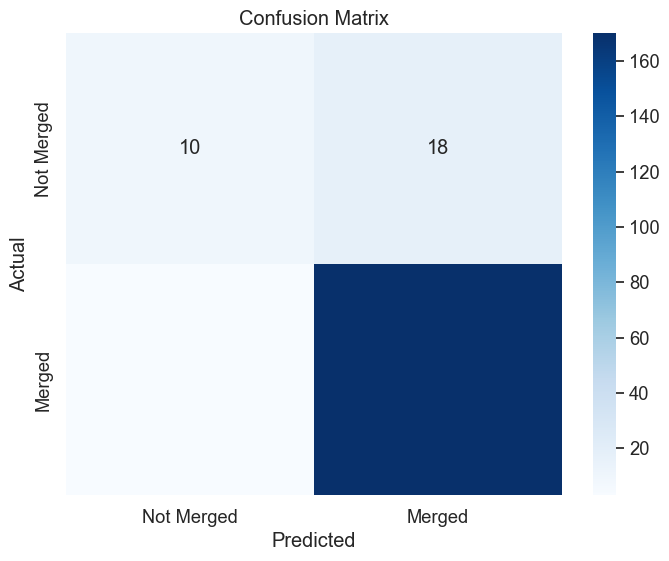

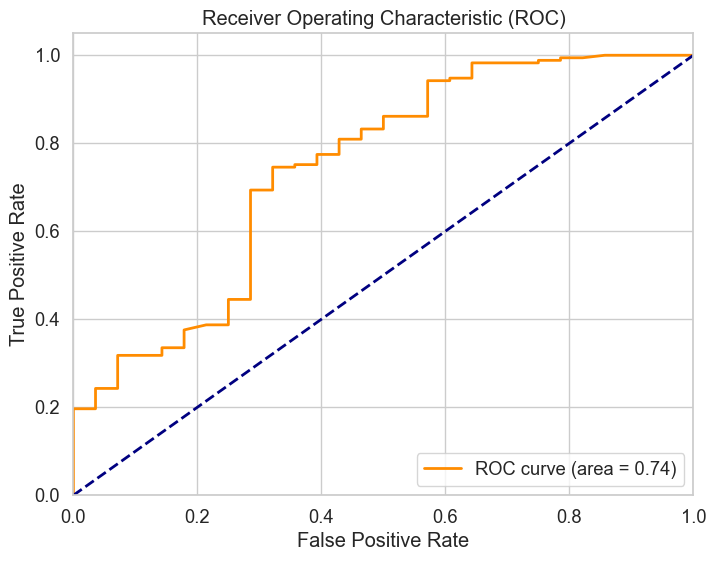

In [45]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['title_length', 'total_comments', 'review_comments', 'issue_comments']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Train a Random Forest classifier
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Calculate baseline accuracy (always predict the majority class)
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"\nBaseline accuracy (always predict merged): {baseline_accuracy:.4f}")
print(f"Improvement over baseline: {(accuracy - baseline_accuracy)*100:.2f}%")

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Merged', 'Merged'],
    yticklabels=['Not Merged', 'Merged']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Feature importance:
                 feature  importance
3           title_length    0.257743
5         total_comments    0.139018
7         issue_comments    0.121655
0               is_jboss    0.097770
2             is_netflix    0.068455
4           has_comments    0.063522
8   is_dependency_update    0.060940
15   has_dependency_info    0.038312
16   has_change_requests    0.036293
14              is_other    0.028996


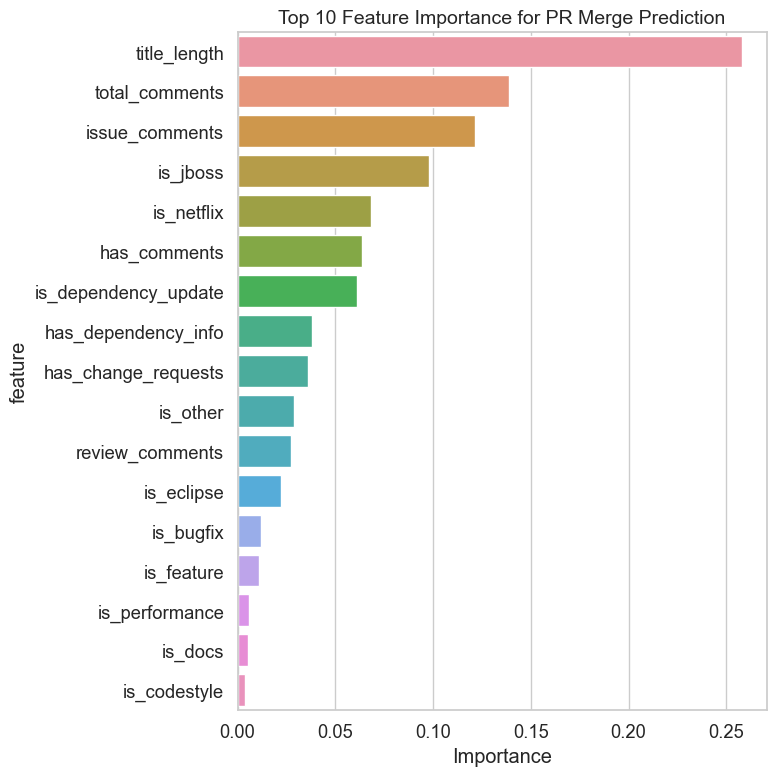

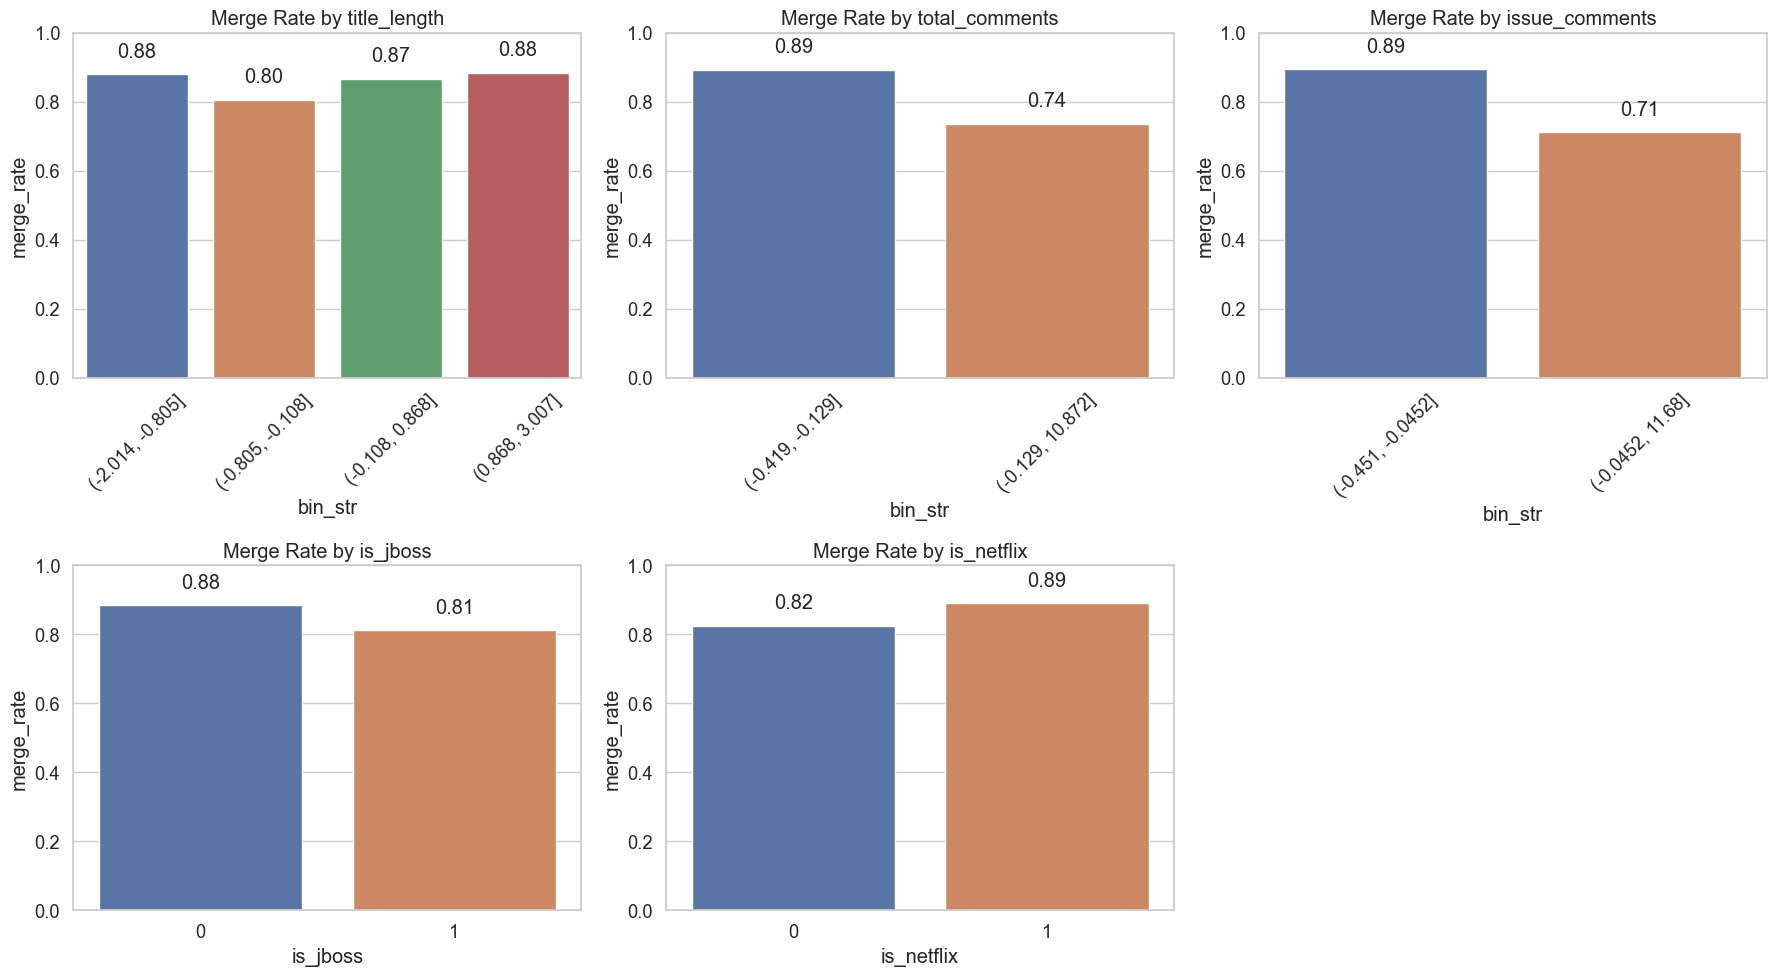

In [60]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(8, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 10 Feature Importance for PR Merge Prediction', fontsize=14)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Analyze the effect of the top features on merge probability
top_features = feature_importance['feature'].head(5).tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# For each top feature, plot its effect on merge rate
for i, feature in enumerate(top_features):
    if feature in ['is_jboss', 'is_eclipse', 'is_netflix', 'has_change_requests', 
                 'has_dependency_info', 'has_comments', 'is_dependency_update',
                 'is_feature', 'is_bugfix', 'is_codestyle', 'is_docs', 
                 'is_performance', 'is_other']:
        # Binary features
        merge_rates = df_closed.groupby(features[feature]).agg(
            merge_rate=('is_merged', 'mean')
        ).reset_index()
        
        sns.barplot(
            x=feature, 
            y='merge_rate', 
            data=merge_rates, 
            ax=axes[i]
        )
        axes[i].set_title(f'Merge Rate by {feature}')
        axes[i].set_ylim(0, 1)
        
        for j, v in enumerate(merge_rates['merge_rate']):
            axes[i].text(j, v + 0.05, f"{v:.2f}", ha='center')
    else:
        # Numerical features
        # Create bins for the numerical feature
        bins = pd.qcut(features[feature], 4, duplicates='drop')
        # Calculate merge rate for each bin
        merge_rates = pd.DataFrame({
            'bin': bins,
            'is_merged': target
        }).groupby('bin').agg(
            merge_rate=('is_merged', 'mean'),
            count=('is_merged', 'count')
        ).reset_index()
        
        # Plot - need to provide column names and data parameter
        bin_strings = merge_rates['bin'].astype(str)
        merge_rates_plot = merge_rates.copy()
        merge_rates_plot['bin_str'] = bin_strings
        
        sns.barplot(
            x='bin_str',  # Use the column name, not the series directly
            y='merge_rate',  # This should be a column name
            data=merge_rates_plot,  # Provide the dataframe
            ax=axes[i]
        )
        axes[i].set_title(f'Merge Rate by {feature}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
        axes[i].set_ylim(0, 1)
        
        for j, v in enumerate(merge_rates['merge_rate']):
            axes[i].text(j, v + 0.05, f"{v:.2f}", ha='center')

# Hide any unused subplots
for i in range(len(top_features), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Cross-validation scores: [0.91044776 0.84577114 0.835      0.86       0.86      ]
Mean CV accuracy: 0.8622 (±0.0259)
Random Forest: 0.8343 (±0.0337)
Logistic Regression: 0.8303 (±0.0400)
Decision Tree: 0.8213 (±0.0404)
SVM: 0.8792 (±0.0225)
KNN: 0.8672 (±0.0278)


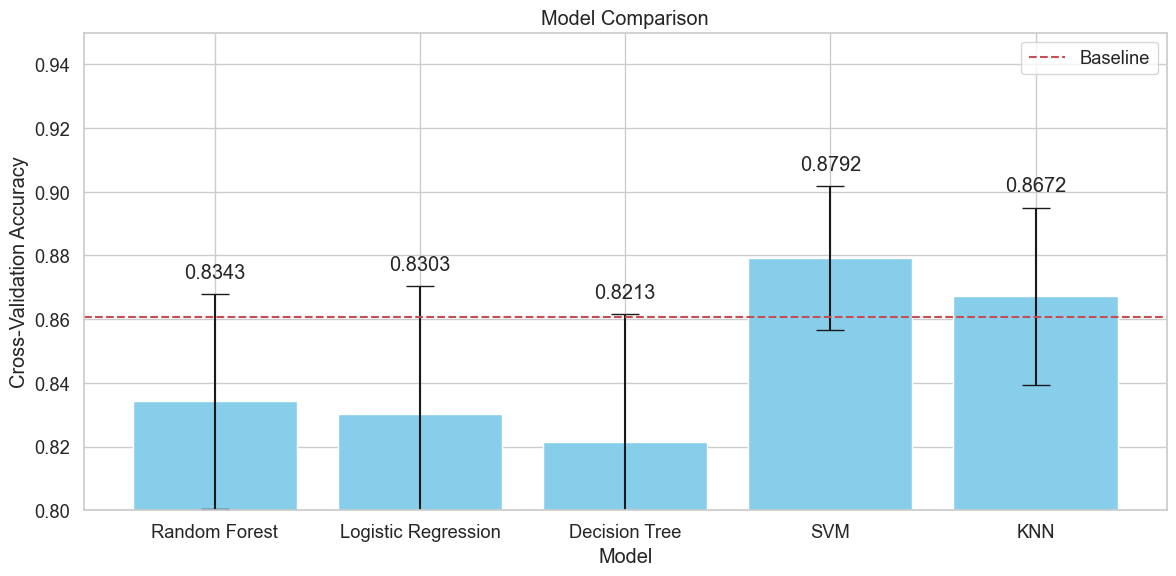

In [61]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, features, target, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Compare with other classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Define classifiers to compare
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Evaluate each classifier
results = {}
for name, classifier in classifiers.items():
    cv_scores = cross_val_score(classifier, features, target, cv=5)
    results[name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std()
    }
    print(f"{name}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Plot model comparison
plt.figure(figsize=(12, 6))
models = list(results.keys())
accuracies = [results[model]['mean_accuracy'] for model in models]
std_errors = [results[model]['std_accuracy'] for model in models]

bars = plt.bar(models, accuracies, yerr=std_errors, capsize=10, color='skyblue')
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison')
plt.ylim(0.80, 0.95)
plt.legend()

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2, 
        accuracies[i] + std_errors[i] + 0.005, 
        f"{accuracies[i]:.4f}", 
        ha='center'
    )

plt.tight_layout()
plt.show()